# Forecasting Covid-19 Outbreak with Machine Learning
The goal of this project is to predict the outbreak trend in the world and in the US using Machine Learning.We will model the global and US trajectories of the outbreak counts of confirmed cases,deaths and recovered cases from the start date of 22 January 2020 to now and predict 10 days in the future.The data source is JHU https://github.com/CSSEGISandData/COVID-19.

## Load Librairies

## Load Datasets

In [323]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import plotly.express as px
import pandas as pd 
import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [324]:
# Get Data
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-13-2020.csv')


In [325]:
# Preview the dataset
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,803,820,832,842,850,856,868,872,876,880
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,750,751,751,752,752,754,755,755,758,760
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,35,36,36,36,43,43,45,45,45,45


# Data Exploration
The goal is to **understand the Data with Descriptive Statistics**.Getting information about countries/regions with confirmed coronavirus cases.
* Summarize .
* Visualize Data.

Data Exploration is the key to getting insights from data.

### Data Munging
Framing data sets in a way that would best serve its purpose of use.

In [326]:
# Choose only columns with dates(Get rid of the first 4 cols)
confirmed = confirmed_df.iloc[:, 4:]
deaths = deaths_df.iloc[:, 4:]
recoveries = recoveries_df.iloc[:, 4:]

In [327]:
# Dataframes of Confirmed,Deaths and Recovered cases for the World and US.
dates = confirmed.keys()
# World
world_cases = []
world_deaths = []
world_recovered = []

# US
us_cases = []
us_deaths = [] 
us_recoveries = [] 

# World mortality rate,recovery and active cases
mortality_rate = []
recovery_rate = [] 
world_active = []

for i in dates:
    cumul_confirmed = confirmed_df[i].sum()
    cumul_death = deaths[i].sum()
    cumul_recovered = recoveries[i].sum()
    
    # World confirmed, deaths, recovered, and active cases
    world_cases.append(cumul_confirmed)
    world_deaths.append(cumul_death)
    world_recovered.append(cumul_recovered)
    world_active.append(cumul_confirmed - (cumul_death + cumul_recovered))
    
    # US confirmed, deaths and recovered cases
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    
    # calculate rates
    mortality_rate.append(cumul_death/cumul_confirmed)
    recovery_rate.append(cumul_recovered/cumul_confirmed) 

In [328]:
# Daily confirmed,deaths and recovered cases(Daily #).
def daily_increase(data):
    d = []
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

def grow_factor(data):
    gf=[]
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            gf.append(data[i]/data[i-1])
    return gf if data[i-1] !=0 else 0 

# Daily confirmed cases in the World and US
world_daily_increase = daily_increase(world_cases)                                
us_daily_increase = daily_increase(us_cases)

# Daily deaths toll in the World and US
world_daily_death = daily_increase(world_deaths)
us_daily_death = daily_increase(us_deaths)                                 

# Daily recoveries in the Wold and US
world_daily_recovery = daily_increase(world_recovered)                                  
us_daily_recovery = daily_increase(us_recoveries)


In [329]:
# Date conversion for visualization and prediction
days_in_future = 10
# Number of days after 1/20/2020 use for prediction(ML)
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
# Number of days after 1/20/2020 use for visualization(EDA)
adjusted_dates = future_forcast[:-10]

### Summary Table of each unique Country in the World
**Confirmed, Deaths, Recoveries, Active cases and Mortality Rate**

In [330]:
# Building the table
unique_countries =  list(latest_data['Country_Region'].unique())
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])
    

In [331]:
# Printing the table
country_df = pd.DataFrame({'Country Name': unique_countries, 'Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap="PuRd")

,Country Name,Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,1390406,84119,243430,1062857,0.060500
1,Russia,242271,2212,48003,192056,0.009130
2,United Kingdom,230985,33264,1032,196689,0.144009
3,Spain,228691,27104,140823,60764,0.118518
4,Italy,222104,31106,112541,78457,0.140052
5,Brazil,190137,13240,78424,98473,0.069634
6,France,178184,27077,58786,92321,0.151961
7,Germany,174098,7861,148700,17537,0.045153
8,Turkey,143114,3952,101715,37447,0.027614
9,Iran,112725,6783,89428,16514,0.060173


## Data Visualization

In [332]:
#Treemap of confirmed cases by country
fig = px.treemap(country_df.sort_values(by='Confirmed Cases', ascending=False).reset_index(drop=True), 
                 path=["Country Name"], values="Confirmed Cases",
                 title='Confirmed Cases by Country',
                 color_discrete_sequence = px.colors.qualitative.G10)
fig.show()

Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate.

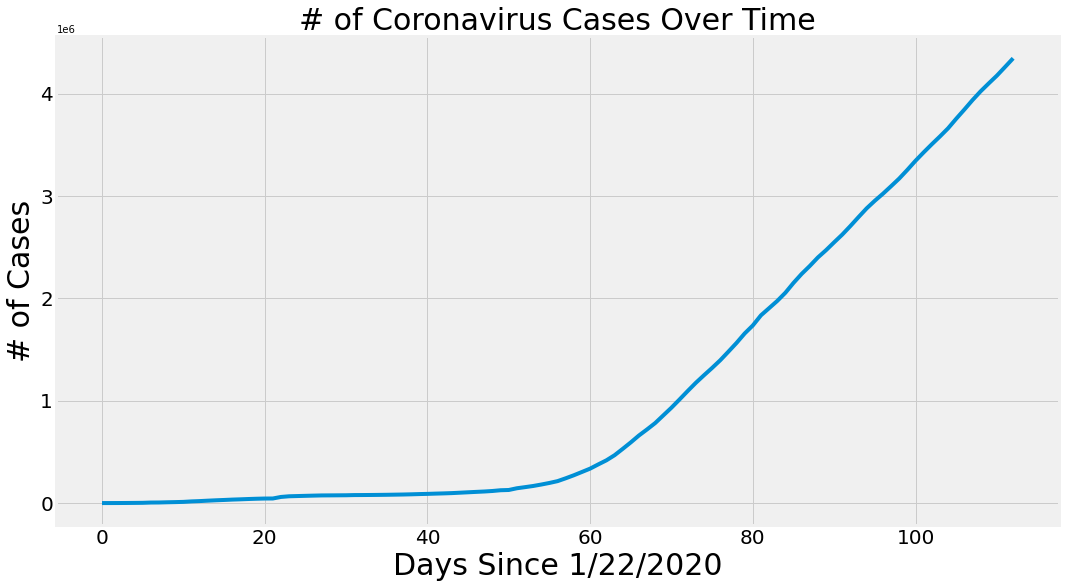

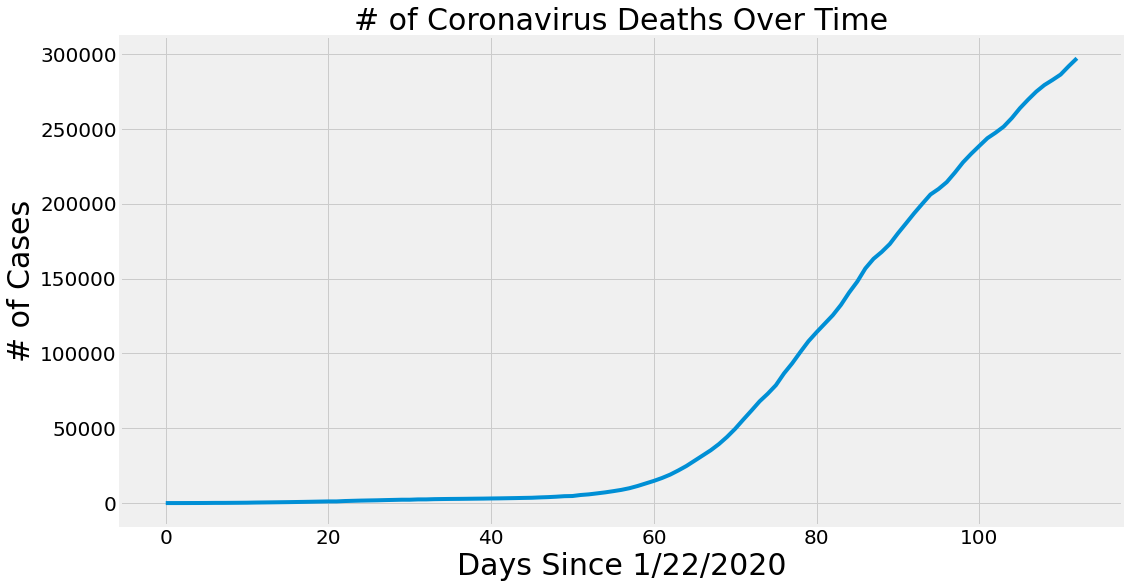

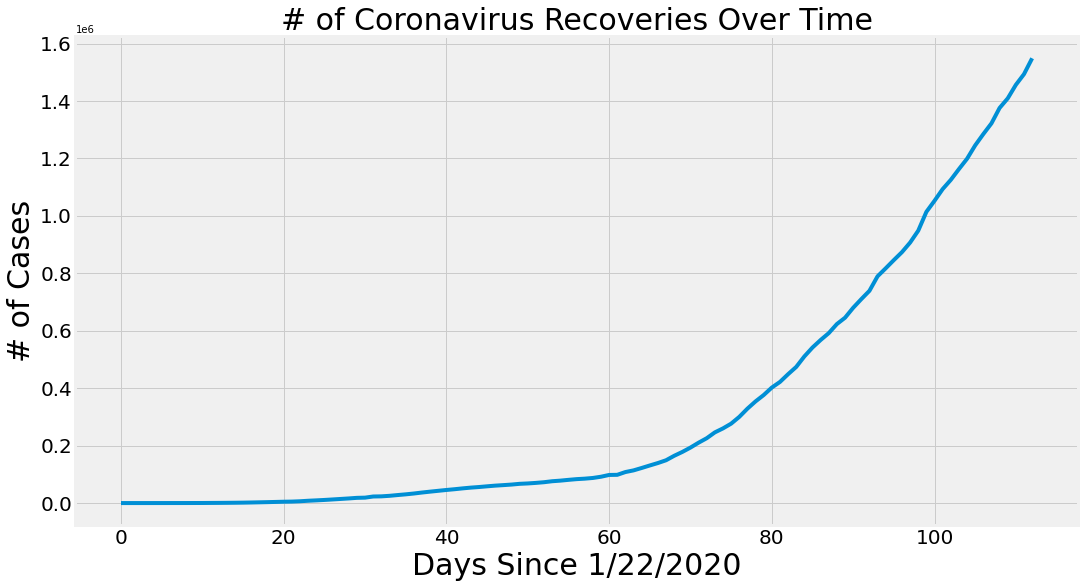

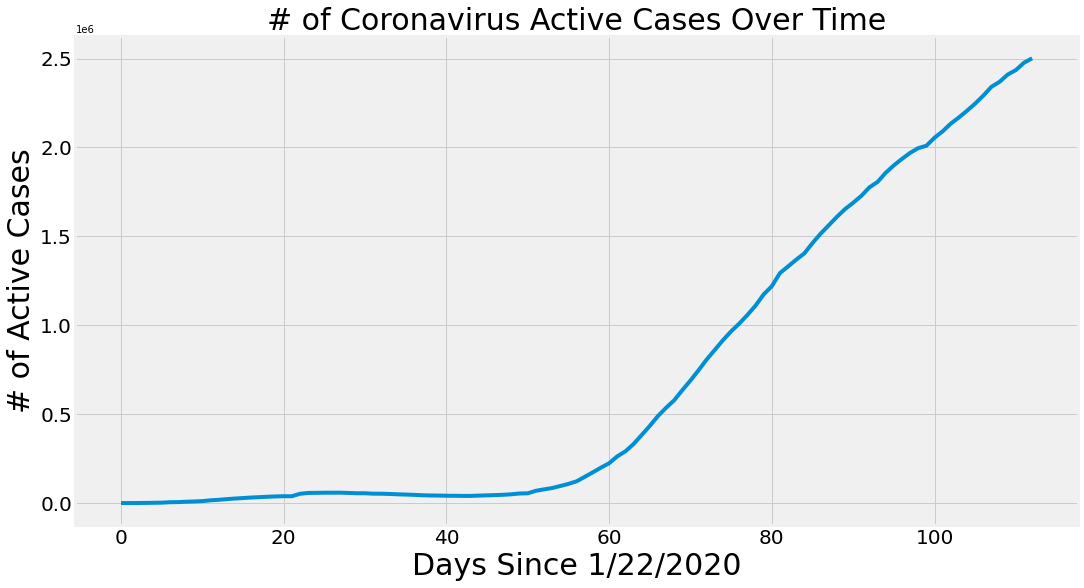

In [333]:
# World cumulative cases of confirmed ,deaths,recoveries and actives
# Since 1/22/2020.
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

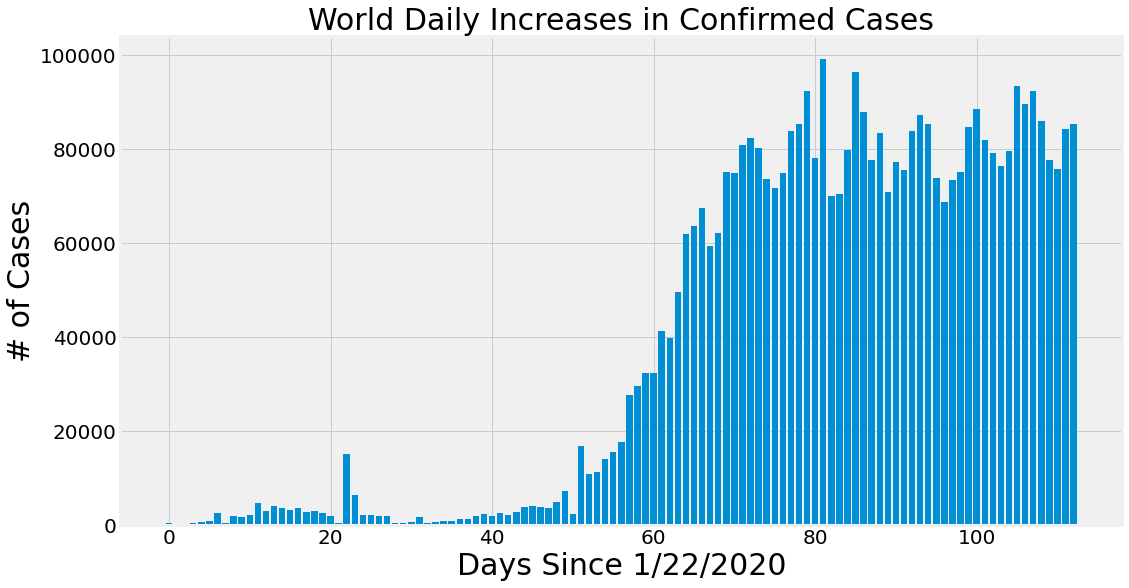

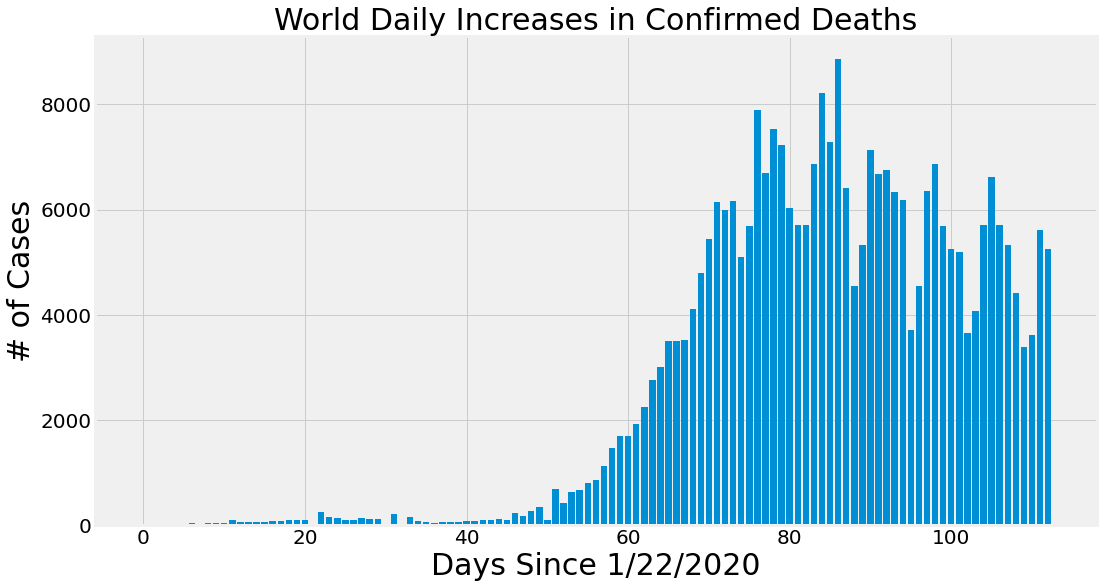

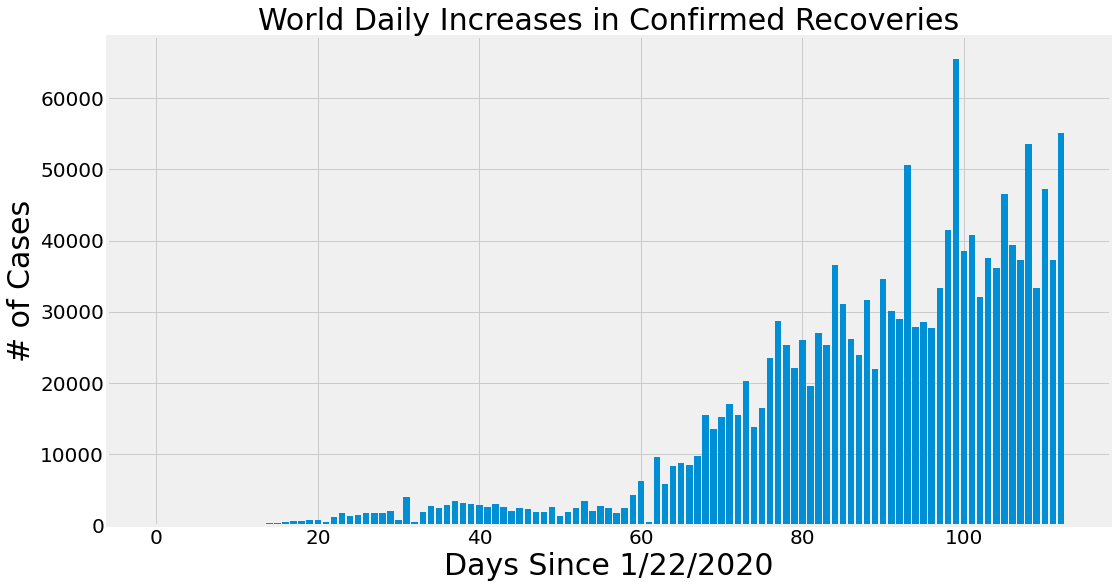

In [334]:
# World Daily cases of confirmed ,deaths,recoveries and actives
# Since 1/22/2020.
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


# # Recovery Rate (worldwide)
# mean_grow_factor = np.mean(confirmed_grow_factor)
# plt.figure(figsize=(16, 9))
# plt.plot(adjusted_dates, confirmed_grow_factor, color='blue')
# plt.axhline(y = mean_grow_factor,linestyle='--', color='black')
# plt.title('Growth Rate of Coronavirus Over Time', size=30)
# plt.legend(['Confirmed Cases Growth', 'y='+str(mean_grow_factor)], prop={'size': 20})
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('Growth Factor', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

# plt.figure(figsize=(16, 9))
# plt.plot(adjusted_dates, confirmed_grow_factor)
# plt.title('World Daily Growth of Confirmed Cases', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('Growth factor', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_death)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# plt.figure(figsize=(16, 9))
# plt.bar(adjusted_dates, death_grow_factor)
# plt.title('World Daily Growth of Deaths', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# plt.figure(figsize=(16, 9))
# plt.bar(adjusted_dates, recovery_grow_factor)
# plt.title('World Daily growth Recoveries', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

###  World Rates

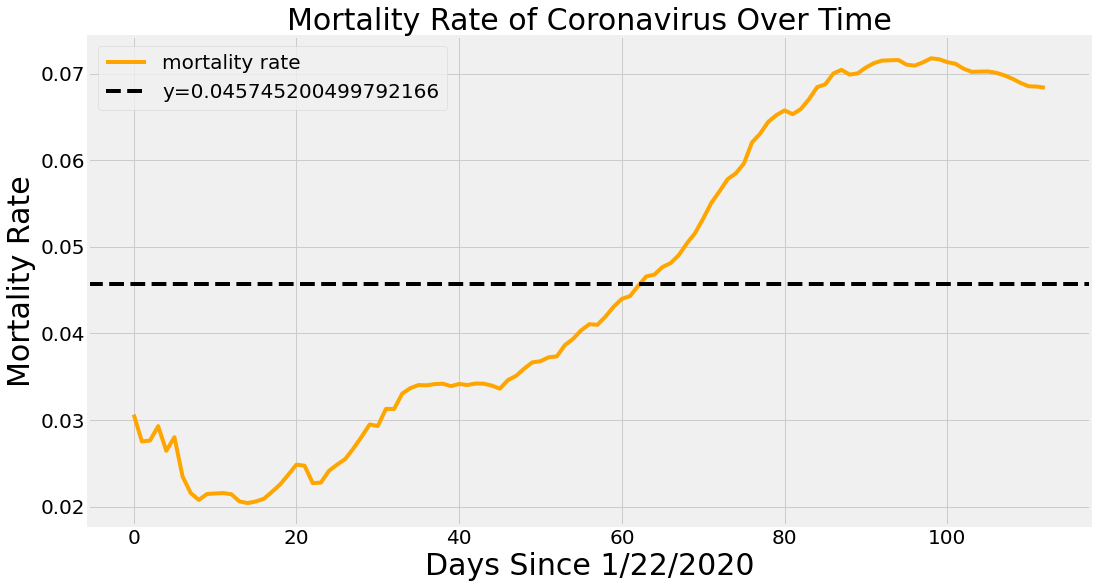

In [335]:
# Mortality Rate (worldwide)
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

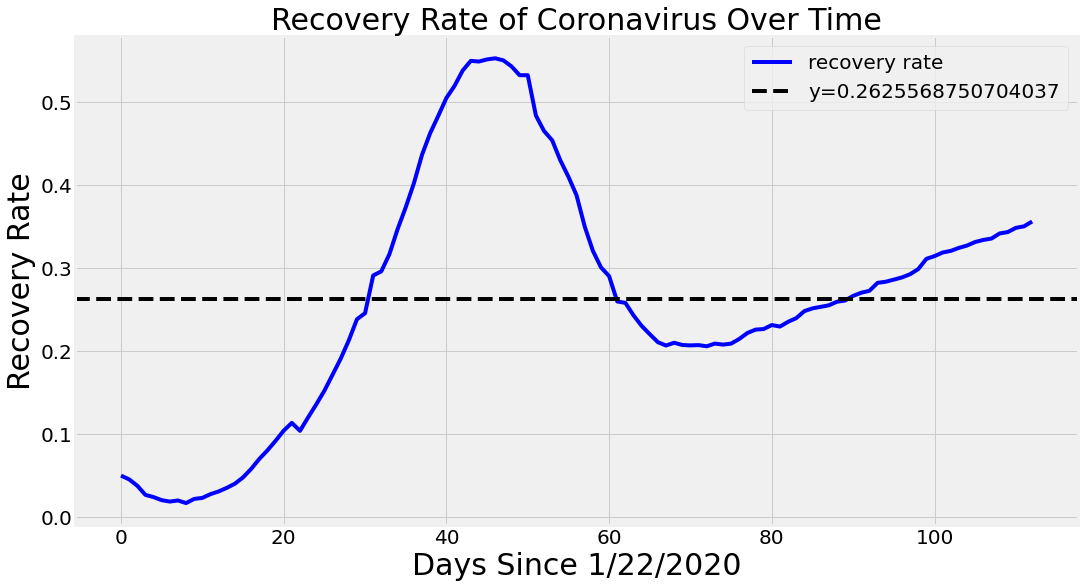

In [336]:
# Recovery Rate (worldwide)
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Country level Visualization:  US for example.

In [337]:
# Country visualization function
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y1)
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y2)
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y3)
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y4)
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

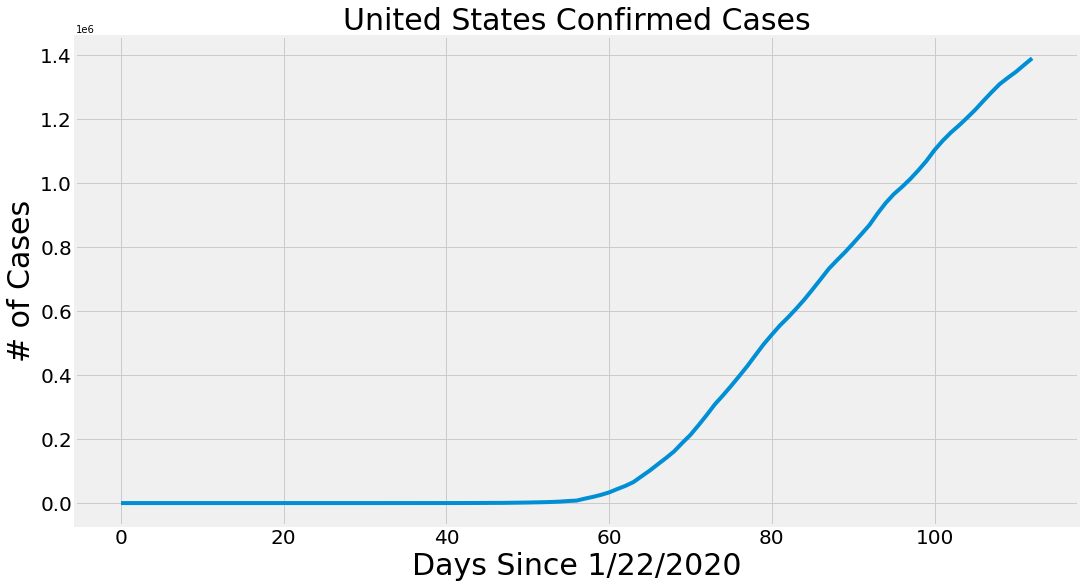

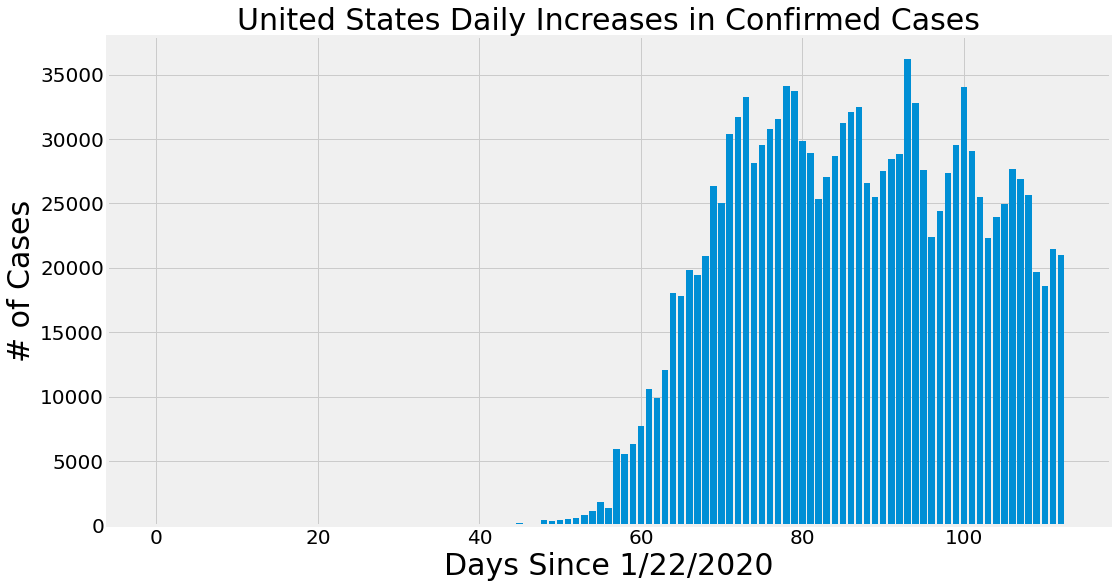

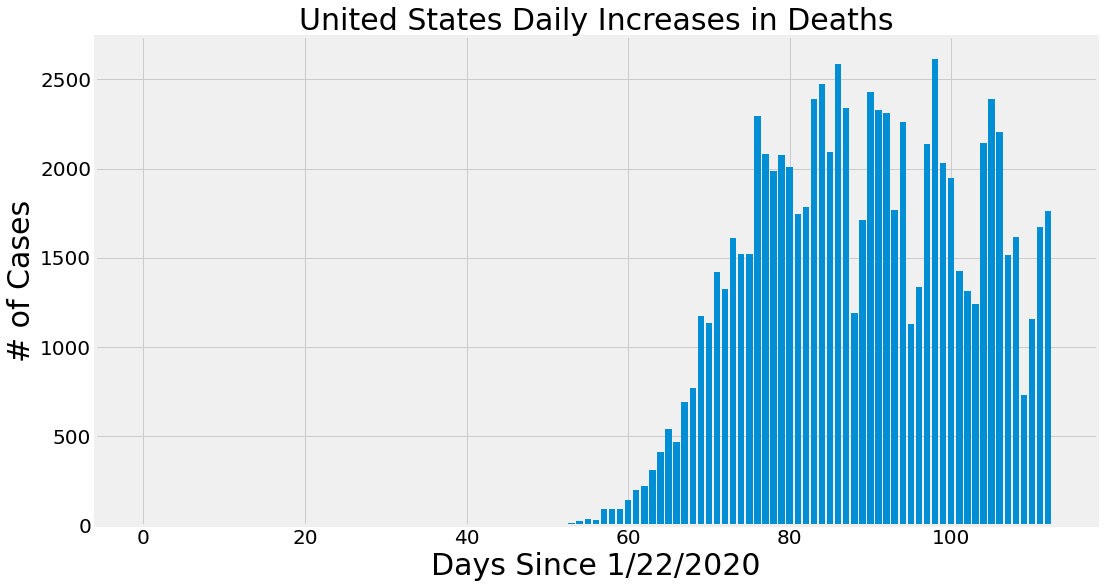

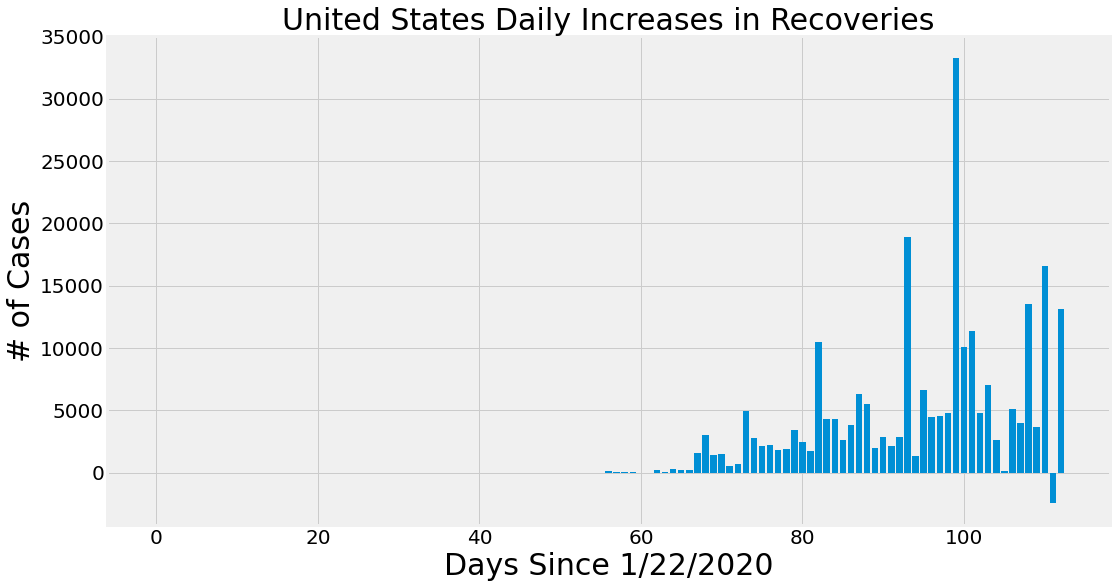

In [338]:
# US Visualization
country_plot(adjusted_dates, us_cases, us_daily_increase, us_daily_death, us_daily_recovery, 'United States')


# Prediction with Machine Learning

### Data Preprocessing(Reshaping for use with ML)

In [339]:
# Number of days after 1/20/2020 use for prediction(ML) back in date format.
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
# Reshape
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)

### Split the Dataset in Training and Testing Datasets.

* Test Dataset size =0.10(10% of the full dataset)

In [340]:
# Split
X=days_since_1_22
Y=world_cases 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, shuffle=False)

In [341]:
# Forcast days
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]



### Model and Training
* Support Vector Model(SVM) ,Bayesian ridge Regressions(NB) and Decision Tree(DT)

#### Support Vector Model(SVM)

In [342]:
# Train SVM(kernel=poly) with preselected best parameters and test
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train, y_train)
svm_pred = svm_confirmed.predict(future_forcast)
print(svm_pred[-5:])

[ 9506225.89101662  9914043.64705195 10335802.38856711 10771856.52226891
 11222566.41107478]


MAE: 1884110.2645638108
MSE: 3950072650875.4517


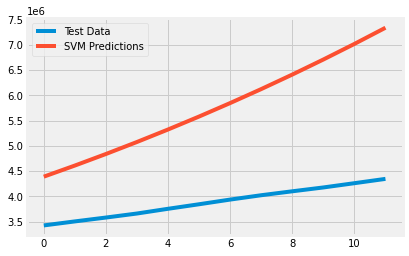

In [343]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test)
plt.plot(y_test)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test))
print('MSE:',mean_squared_error(svm_test_pred, y_test))

MAE: 1884110.2645638108
MSE: 3950072650875.4517


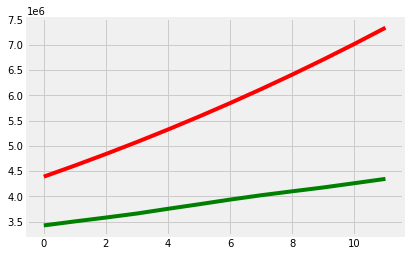

In [344]:
# check against testing data
from sklearn.svm import SVC
svm_test_pred = svm_confirmed.predict(X_test) 
plt.plot(svm_test_pred,color='red') 
plt.plot(y_test,color="green") 
print('MAE:', mean_absolute_error(svm_test_pred,y_test)) 
print('MSE:', mean_squared_error(svm_test_pred,y_test))

In [345]:
# Cross validation with neg_mean_squared_error
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
model = SVR(gamma='auto')
scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print(results.mean())

-2622287013710.751


#### Bayesian ridge Regressions(NB) 

In [346]:
# bayesian ridge regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}
bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train)
bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=0)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [347]:
# finding the best parameters for our predictive model
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 0.0001,
 'lambda_1': 1e-07,
 'alpha_2': 1e-07,
 'alpha_1': 0.0001}

In [348]:
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test))

MAE: 932173.254772562
MSE: 978394703477.4286


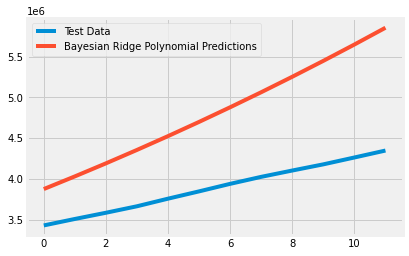

In [349]:
plt.plot(y_test)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [350]:
# Cross Validation with neg_mean_squared_error
from sklearn.linear_model import Ridge
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
model = Ridge()
scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print(results.mean())

-382518710378.8104


#### Decision Tree(DT)

In [351]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
model = DecisionTreeRegressor()
scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print(results.mean())

-3119950251.772727


#### Compare Models

SVM: -3173747148.104545 (1136242165.060184)
NB: -3119950251.772727 (1200788424.301717)
DT: -3119950251.772727 (1200788424.301717)


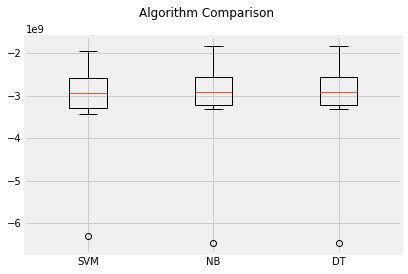

In [352]:
models = []
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('DT', DecisionTreeClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Predict the outbreak 10 days in the future

In [353]:
# Prediction function
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

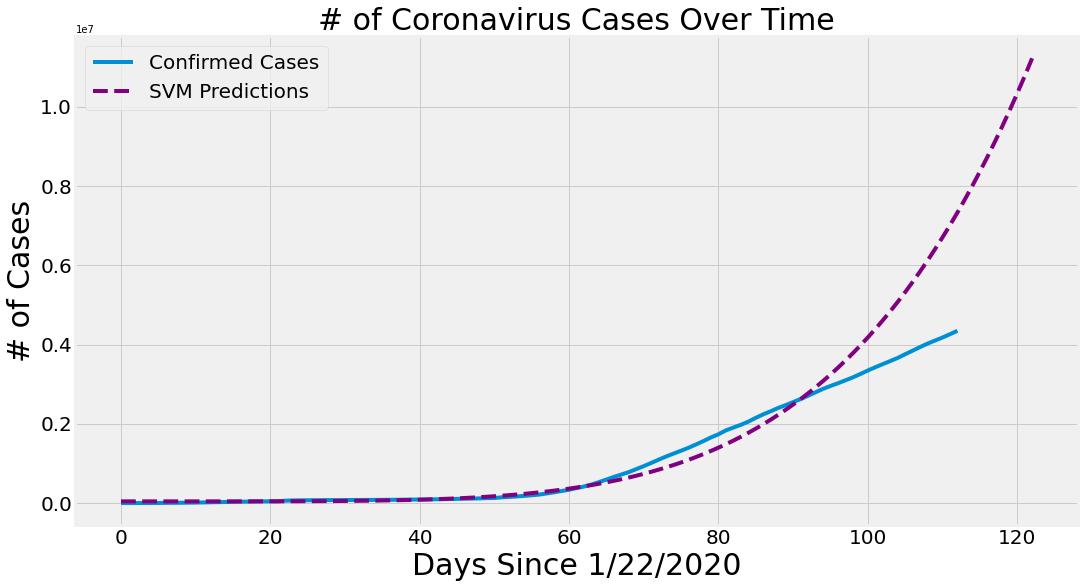

In [354]:
# Predict the World Confirmed Cases using SVM Model
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')


In [355]:
# 10 Days prediction of World confirmed cases using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,05/14/2020,7664258.0
1,05/15/2020,8007482.0
2,05/16/2020,8362963.0
3,05/17/2020,8731025.0
4,05/18/2020,9112001.0
5,05/19/2020,9506226.0
6,05/20/2020,9914044.0
7,05/21/2020,10335802.0
8,05/22/2020,10771857.0
9,05/23/2020,11222566.0


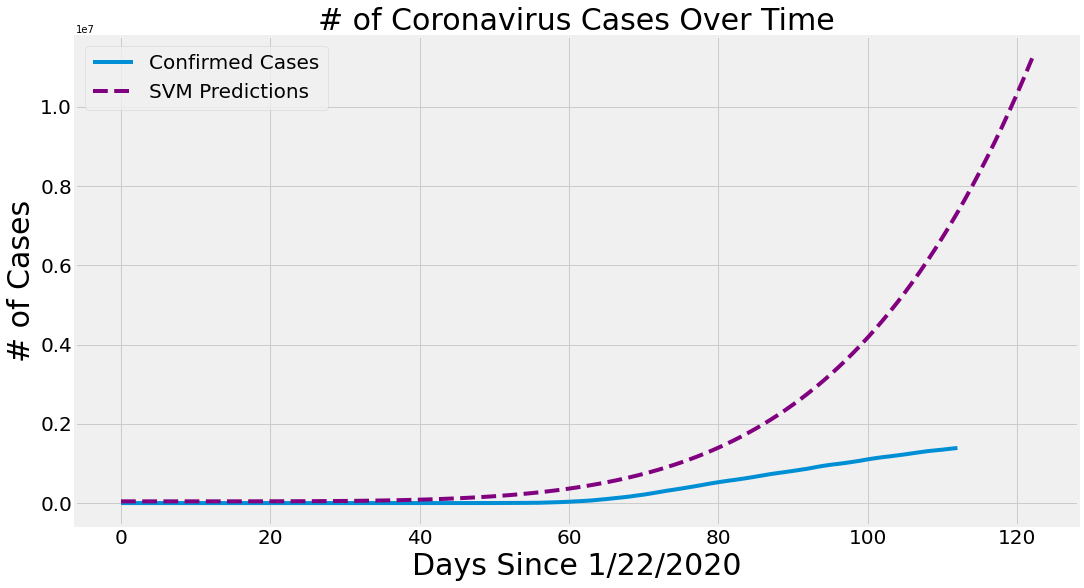

In [356]:
# Predict the US Confirmed Cases using SVM Model
plot_predictions(adjusted_dates, us_cases, svm_pred, 'SVM Predictions', 'purple')


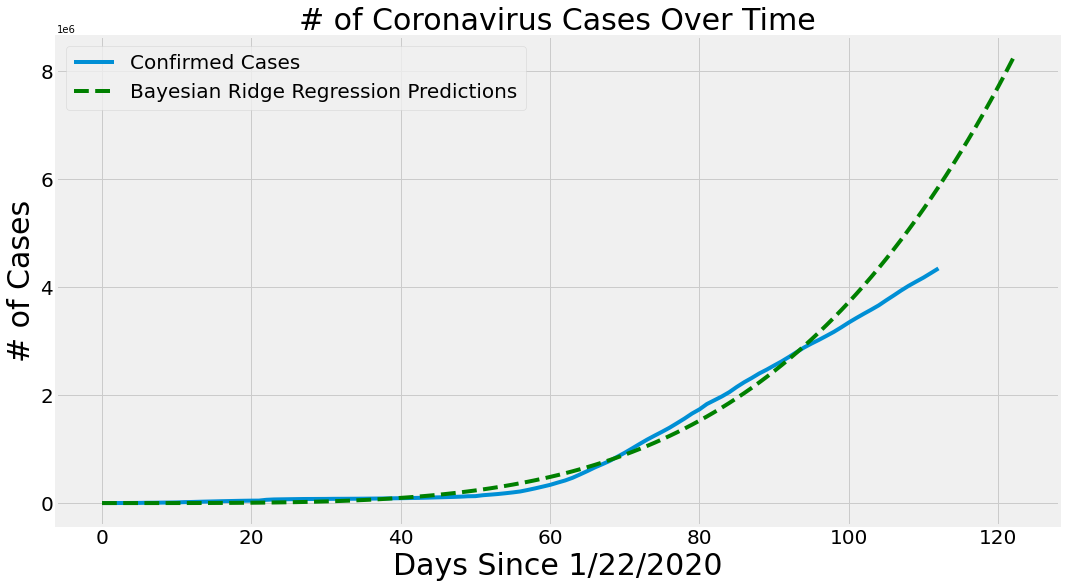

In [357]:
# Predict the World Confirmed Cases using Bayesian Ridge Regression Model
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')


In [358]:
# 10 Days prediction of the World confirmed cases using Bayesian Ridge
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,05/14/2020,6066713.0
1,05/15/2020,6284082.0
2,05/16/2020,6507240.0
3,05/17/2020,6736290.0
4,05/18/2020,6971334.0
5,05/19/2020,7212476.0
6,05/20/2020,7459820.0
7,05/21/2020,7713472.0
8,05/22/2020,7973539.0
9,05/23/2020,8240127.0


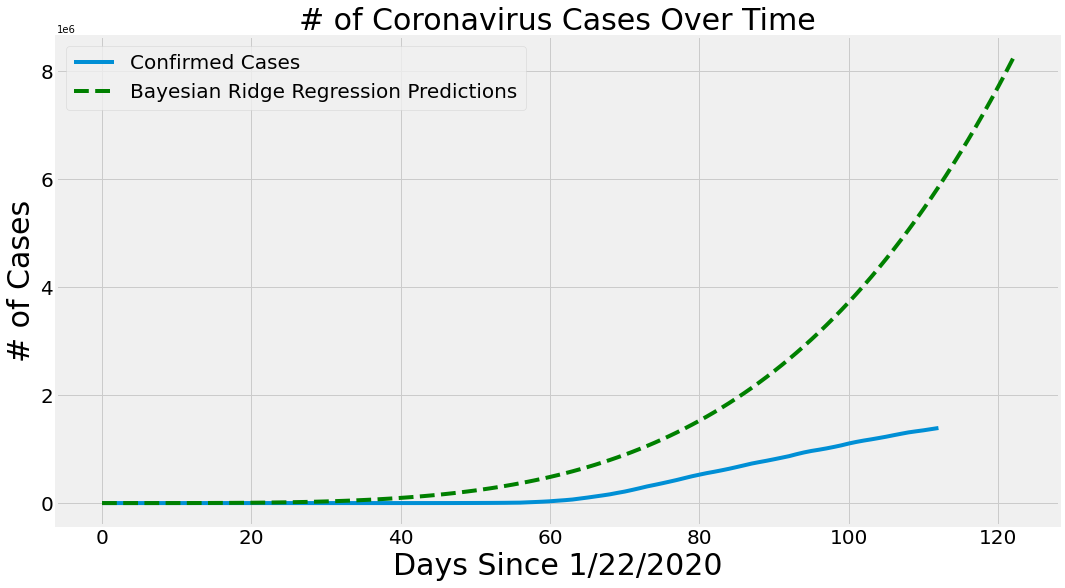

In [359]:
# Predict the US Confirmed Cases using Bayesian Ridge Regression Model
plot_predictions(adjusted_dates, us_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')


### Save model for later use

In [360]:
# Save Model Using joblib
from joblib import dump
from joblib import load
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)
# Fit the model 
model = SVR(gamma='auto')
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
dump(model, filename)

['finalized_model.sav']

In [361]:
# load the model from disk
loaded_model = load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

-0.5747602729873469


## Conclusion
While we try our best to make accurate projections,the outcomes of the models  are fare from the reality.The under performance is due to the fact that the currently available datasets are still too small to train a machine.The model also doesn’t take into consideration the measures taken by governments to reduce the spread of the infection that's why we did a short forecast horizon of 10 days. 